# 🧪 NMR Deep Learning Enhancement Project 🚀

## ✅ Goals & To-Dos

1. **Prepare FID Data** 📊  
   - Load raw FID using `nmr.load_fid_and_preview`  
   - Normalize and format for PyTorch `(batch, 1, length)`  

2. **Build DL Model** 🤖  
   - 1D Convolutional Autoencoder or Dilated Conv Network  
   - Input: raw FID  
   - Output: enhanced / denoised FID  

3. **Train Model** 🏋️‍♂️  
   - Start with **simulated FIDs** (damped sinusoids + noise)  
   - Later fine-tune on **experimental FIDs**  

4. **Integrate With Existing Pipeline** 🔗  
   - Feed `enhanced_FID` into `compute_fft_spectrum`  
   - Run peak detection, integration, and J-coupling analysis as usual  

5. **Compare Results** 📈  
   - Original vs enhanced FID → FFT → peaks → integrals  
   - Evaluate **noise reduction, peak clarity, and acquisition efficiency**  

6. **Optional Advanced Steps** ✨  
   - End-to-end model: partial FID → predicted spectrum  
   - Explore **super-resolution/extrapolation** to reduce acquisition time  

---

💡 **Tip:** Keep the DL module modular so it can be swapped in/out without breaking existing code.  


In [13]:
# Single-cell: physics-aware training with combined loss + curriculum + real-FID overfit + inference and plots
import math, time, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
import functions.nmr_function as nmr
from importlib import reload

          X      Real  Imaginary
0  0.000000  0.000003   0.000009
1  0.000133 -0.001235  -0.003140
2  0.000267  0.050601   0.188029
3  0.000400  0.019175   0.365893
4  0.000533 -0.136525  -0.611649


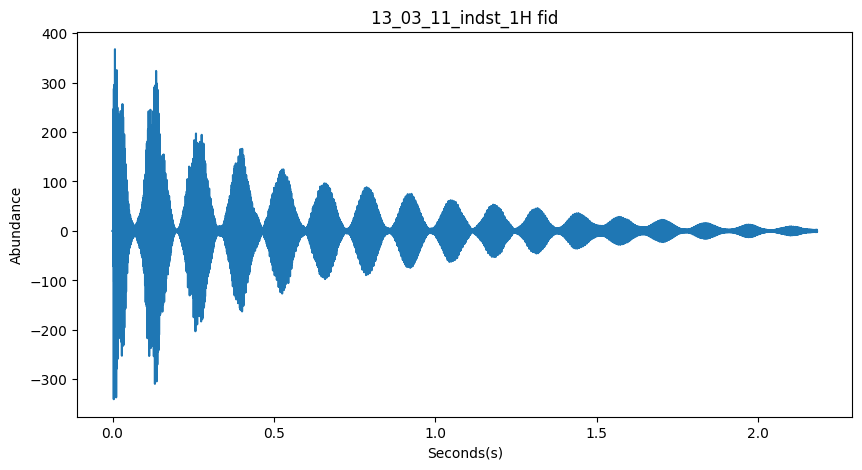

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': '13_03_11_indst_1H fid'}, xlabel='Seconds(s)', ylabel='Abundance'>)

In [16]:
reload(nmr)

url = r"https://raw.githubusercontent.com/Quintinlf/NMR-Project/main/spring_semester_2025/13_03_11_indst_1H%20fid.asc"
df, name = nmr.load_fid_and_preview(url)

# Ensure array for downstream cells
data = df if isinstance(df, np.ndarray) else df.to_numpy()
nmr.plot_fid(data, title=name, xcol=0, ycol=1, xlabel="Seconds(s)", ylabel="Abundance", invert_x=False)

In [17]:
# ---- 0) Device + AMP ----
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
try:
    torch.set_float32_matmul_precision('high')
except Exception:
    pass
if use_cuda:
    torch.backends.cudnn.benchmark = True
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler(enabled=True)
else:
    from contextlib import nullcontext
    autocast = lambda enabled=False: nullcontext()
    class _Noop:
        def scale(self, x): return x
        def step(self, opt): opt.step()
        def update(self): pass
    scaler = _Noop()


In [18]:
# Real-data preprocessing: baseline removal + tail RMS scaling (preserves noise scale)
L = sig.shape[1]
tail = slice(int(0.8 * L), L)
baseline = sig[:, tail].mean(axis=1, keepdims=True)
sig = sig - baseline

tail_rms = np.sqrt((sig[:, tail] ** 2).mean(axis=1, keepdims=True) + 1e-12)
sig = sig / tail_rms

fid_tensor = torch.from_numpy(sig).unsqueeze(0).to(device)  # (1,2,L)

# ...existing code...
# ---- 2) Physics params + T2 estimate ----
dt = float(data[1, 0] - data[0, 0])  # dwell time (s)
gamma_Hz_per_T = 42.57747892e6       # 1H gyromagnetic ratio (Hz/T)

# Set spectrometer frequency directly (Hz)
nu0_Hz = 399.78219838e6              # 399.78219838 MHz
nu0_MHz = nu0_Hz / 1e6

# If you prefer using B0 (Tesla), use: B0_T = 399.78219838 / 42.57747892  # ≈ 9.39 T, then nu0_Hz = gamma_Hz_per_T * B0_T

nyquist_hz = 1.0 / (2.0 * dt)
nyquist_ppm = nyquist_hz / nu0_MHz
# ...existing code...


In [5]:
@torch.no_grad()
def _estimate_t2(fid_1x2xL: torch.Tensor, dt: float, frac: float = 0.25) -> float:
    r = fid_1x2xL[0, 0]
    i = fid_1x2xL[0, 1]
    env = torch.clamp(torch.sqrt(r * r + i * i), min=1e-12)
    n = max(16, int(frac * env.shape[-1]))
    t = torch.arange(n, device=env.device, dtype=env.dtype) * dt
    y = torch.log(env[:n])
    A = torch.stack([torch.ones_like(t), t], dim=1)  # [n,2]
    sol = torch.linalg.lstsq(A, y.unsqueeze(1)).solution  # [2,1]
    b = float(sol[1])
    T2 = (-1.0 / b) if b < 0 else (0.2 * n * dt)
    return float(max(T2, 1e-6))

T2_est = _estimate_t2(fid_tensor.float(), dt)
print(f"dt={dt:.6g}s | ν0={nu0_MHz:.3f} MHz | Nyquist≈{nyquist_ppm:.2f} ppm | T2_est≈{T2_est:.3f}s")

# ---- 3) Physics-aware synthetic generator (match real preprocessing; add optional colored noise) ----
def synth_batch_phys(batch_size=8, L=2048, dt=dt, nu0_MHz=nu0_MHz,
                     nyquist_ppm=nyquist_ppm, n_comp_min=2, n_comp_max=6,
                     T2_range=(0.5 * T2_est, 1.5 * T2_est), snr_std=0.03,
                     colored_noise=True, device=device):
    t = torch.arange(L, device=device) * dt
    clean = torch.zeros(batch_size, 2, L, device=device)

    ppm_lo = 0.15
    ppm_hi = max(ppm_lo * 1.2, nyquist_ppm * 0.9)  # keep within SW

    for b in range(batch_size):
        n_comp = torch.randint(n_comp_min, n_comp_max + 1, (1,), device=device).item()
        sig_r = torch.zeros(L, device=device)
        sig_i = torch.zeros(L, device=device)
        for _ in range(n_comp):
            A = 0.5 + 0.8 * torch.rand((), device=device)
            ppm = ppm_lo + (ppm_hi - ppm_lo) * torch.rand((), device=device)
            f_hz = ppm * nu0_MHz
            phi = 2 * math.pi * torch.rand((), device=device)
            T2c_low, T2c_high = T2_range
            T2c_low = float(max(1e-3, T2c_low))
            T2c_high = float(max(1e-3, T2c_high))
            if T2c_high < T2c_low:
                T2c_low, T2c_high = T2c_high, T2c_low
            T2c = T2c_low + (T2c_high - T2c_low) * torch.rand((), device=device)
            env = torch.exp(-t / T2c)
            arg = 2 * math.pi * f_hz * t + phi
            sig_r += A * env * torch.cos(arg)
            sig_i += A * env * torch.sin(arg)
        # Match real-data preprocessing (baseline + tail RMS scaling)
        tail = slice(int(0.8 * L), L)
        base_r = sig_r[tail].mean(); base_i = sig_i[tail].mean()
        sig_r = sig_r - base_r; sig_i = sig_i - base_i
        tail_rms = torch.sqrt((sig_r[tail] ** 2).mean() + (sig_i[tail] ** 2).mean() + 1e-12)
        sig_r = sig_r / (tail_rms + 1e-8)
        sig_i = sig_i / (tail_rms + 1e-8)
        # Small linear drift
        drift = 0.003 * torch.linspace(0, 1, L, device=device)
        sig_r = sig_r + drift
        clean[b, 0] = sig_r
        clean[b, 1] = sig_i

    # White noise
    noise = snr_std * torch.randn_like(clean)

    # Optional colored noise (1/f shaping)
    if colored_noise:
        H = torch.fft.rfft(torch.randn(batch_size, 2, L, device=device), dim=-1)
        freqs = torch.fft.rfftfreq(L, d=dt, device=device)
        shaping = 1.0 / (freqs.clamp_min(1.0))  # avoid inf at DC
        H = H * shaping.view(1, 1, -1)
        col = torch.fft.irfft(H, n=L, dim=-1)
        col = col / (col.std(dim=-1, keepdim=True) + 1e-8) * snr_std
        noise = 0.5 * noise + 0.5 * col

    noisy = clean + noise
    return noisy, clean

# ---- 4) Combined loss (normalized freq magnitude + envelope-to-target) ----
def _to_complex(x):  # x: (B,2,L)
    return torch.complex(x[:, 0], x[:, 1])

def _freq_mag_norm_c(zc):  # zc: (B,L) complex
    Z = torch.fft.fft(zc, dim=-1)
    # keep non-negative frequencies like rfft
    pos_len = zc.shape[-1] // 2 + 1
    Zpos = Z[..., :pos_len]
    mag = torch.abs(Zpos)
    mag = mag / (mag.amax(dim=-1, keepdim=True) + 1e-8)
    return mag

def _env_norm(x):  # x: (B,2,L)
    e = torch.sqrt(x[:, 0] ** 2 + x[:, 1] ** 2)
    n0 = max(8, int(0.02 * e.shape[-1]))
    s = e[:, :n0].mean(dim=-1, keepdim=True) + 1e-8
    return e / s

def combined_loss(pred, target, dt=dt, w_time=0.6, w_freq=0.35, w_env=0.05):
    # Time-domain MSE
    lt = torch.mean((pred - target) ** 2)
    # Frequency magnitude loss (phase-invariant, per-sample normalized)
    lf = torch.mean((_freq_mag_norm_c(_to_complex(pred)) - _freq_mag_norm_c(_to_complex(target))) ** 2)
    # Envelope matching to target (scale-normalized by early-time mean)
    le = torch.mean((_env_norm(pred) - _env_norm(target)) ** 2)
    return w_time * lt + w_freq * lf + w_env * le

# ---- 5) Model definition ----
class DilatedResBlock(nn.Module):
    def __init__(self, channels, dilation=1, k=11):
        super().__init__()
        pad = dilation * ((k - 1) // 2)
        self.conv1 = nn.Conv1d(channels, channels, k, padding=pad, dilation=dilation)
        self.conv2 = nn.Conv1d(channels, channels, k, padding=pad, dilation=dilation)
    def forward(self, x):
        h = F.relu(self.conv1(x))
        h = self.conv2(h)
        return F.relu(x + h)

class DenoiseNetPhysics(nn.Module):
    def __init__(self, in_ch=2, hidden=64, k=11, dilations=(1, 2, 4, 8, 16, 32)):
        super().__init__()
        self.inp = nn.Conv1d(in_ch, hidden, k, padding=(k - 1) // 2)
        self.blocks = nn.Sequential(*[DilatedResBlock(hidden, d, k) for d in dilations])
        self.out = nn.Conv1d(hidden, in_ch, k, padding=(k - 1) // 2)  # residual
    def forward(self, x):
        h = F.relu(self.inp(x))
        h = self.blocks(h)
        resid = self.out(h)
        return x + resid

def _init_weights(m):
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

dt=0.00013328s | ν0=399.782 MHz | Nyquist≈9.38 ppm | T2_est≈3.849s


In [6]:
model_physics = DenoiseNetPhysics().apply(_init_weights).to(device)
opt = torch.optim.Adam(model_physics.parameters(), lr=8e-4, weight_decay=1e-4)

# ---- 6) Curriculum training with combined_loss ----
EPOCHS = 3
STEPS_PER_EPOCH = 40
BATCH_SIZE = 8
CROP_LEN = 2048
NOISE_SCHEDULE = [0.04, 0.035, 0.03]  # per-epoch noise (post tail-RMS scale)



Training with combined loss...


C:\Users\Windows User\AppData\Local\Temp\ipykernel_9576\1341512420.py:16: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  running += float(loss)


epoch 1: train_loss=28.834799 | val base=0.001664 model=0.201718 ΔSNR=-20.83 dB
epoch 2: train_loss=0.085840 | val base=0.001698 model=0.091339 ΔSNR=-17.31 dB
epoch 3: train_loss=0.050521 | val base=0.001463 model=0.056640 ΔSNR=-15.88 dB
train time: 156.5s

Overfitting single real FID (sanity check)...
step 50: loss=5.128681e-04
step 100: loss=1.913008e-05
step 150: loss=4.396483e-06
step 200: loss=1.217896e-06

Shapes → input: (1, 2, 16384) denoised: (1, 2, 16384)


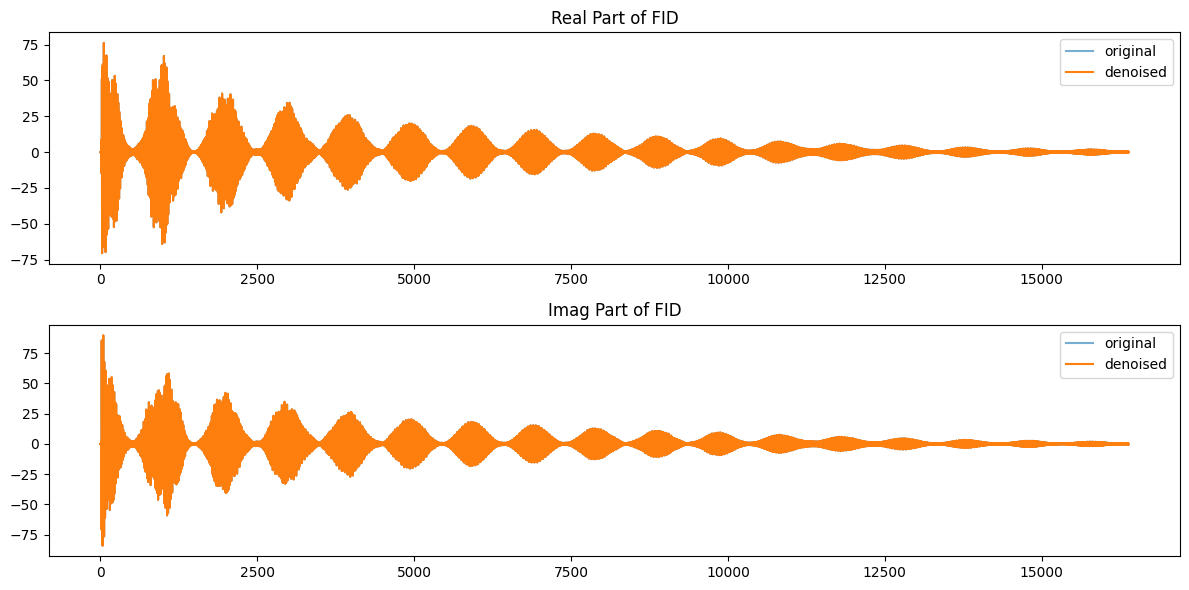

Done. This cell trained with combined_loss (normalized freq/envelope), validated ΔSNR, overfit a real FID, and plotted results.


In [7]:

print("\nTraining with combined loss...")
t0 = time.perf_counter()
for ep in range(EPOCHS):
    model_physics.train()
    running = 0.0
    sn = NOISE_SCHEDULE[min(ep, len(NOISE_SCHEDULE) - 1)]
    for _ in range(STEPS_PER_EPOCH):
        x, y = synth_batch_phys(batch_size=BATCH_SIZE, L=CROP_LEN, snr_std=sn, colored_noise=True)
        opt.zero_grad(set_to_none=True)
        with autocast(enabled=use_cuda):
            pred = model_physics(x)
            loss = combined_loss(pred, y, dt=dt)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        running += float(loss)

    # Validation snapshot vs baseline at target noise
    model_physics.eval()
    with torch.no_grad():
        xv, yv = synth_batch_phys(batch_size=64, L=CROP_LEN, snr_std=NOISE_SCHEDULE[-1], colored_noise=True)
        with autocast(enabled=use_cuda):
            pv = model_physics(xv)
        mse_noisy = torch.mean((xv - yv) ** 2).item()
        mse_pred = torch.mean((pv - yv) ** 2).item()
        snr_impr_db = 20 * math.log10((mse_noisy ** 0.5) / max(mse_pred ** 0.5, 1e-12))
    print(f"epoch {ep+1}: train_loss={running/STEPS_PER_EPOCH:.6f} | val base={mse_noisy:.6f} model={mse_pred:.6f} ΔSNR={snr_impr_db:.2f} dB")

print(f"train time: {time.perf_counter()-t0:.1f}s")

# ---- 7) Overfit a single real FID (sanity check) ----
print("\nOverfitting single real FID (sanity check)...")
model_physics.train()
x_real = fid_tensor.clone()  # (1,2,L)
y_real = x_real.clone()
opt_overfit = torch.optim.Adam(model_physics.parameters(), lr=1e-3)
for i in range(200):
    opt_overfit.zero_grad(set_to_none=True)
    with autocast(enabled=use_cuda):
        pred = model_physics(x_real)
        loss = combined_loss(pred, y_real, dt=dt)
    scaler.scale(loss).backward()
    scaler.step(opt_overfit)
    scaler.update()
    if (i + 1) % 50 == 0:
        print(f"step {i+1}: loss={float(loss):.6e}")

# ---- 8) Inference on real FID + plots ----
model_physics.eval()
with torch.no_grad():
    with autocast(enabled=use_cuda):
        denoised = model_physics(fid_tensor).cpu()  # (1,2,L)

print("\nShapes → input:", tuple(fid_tensor.shape), "denoised:", tuple(denoised.shape))

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title("Real Part of FID")
plt.plot(fid_tensor[0, 0].detach().cpu().numpy(), label="original", alpha=0.6)
plt.plot(denoised[0, 0].detach().cpu().numpy(), label="denoised", lw=1.5)
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Imag Part of FID")
plt.plot(fid_tensor[0, 1].detach().cpu().numpy(), label="original", alpha=0.6)
plt.plot(denoised[0, 1].detach().cpu().numpy(), label="denoised", lw=1.5)
plt.legend()
plt.tight_layout()
plt.show()

print("Done. This cell trained with combined_loss (normalized freq/envelope), validated ΔSNR, overfit a real FID, and plotted results.")

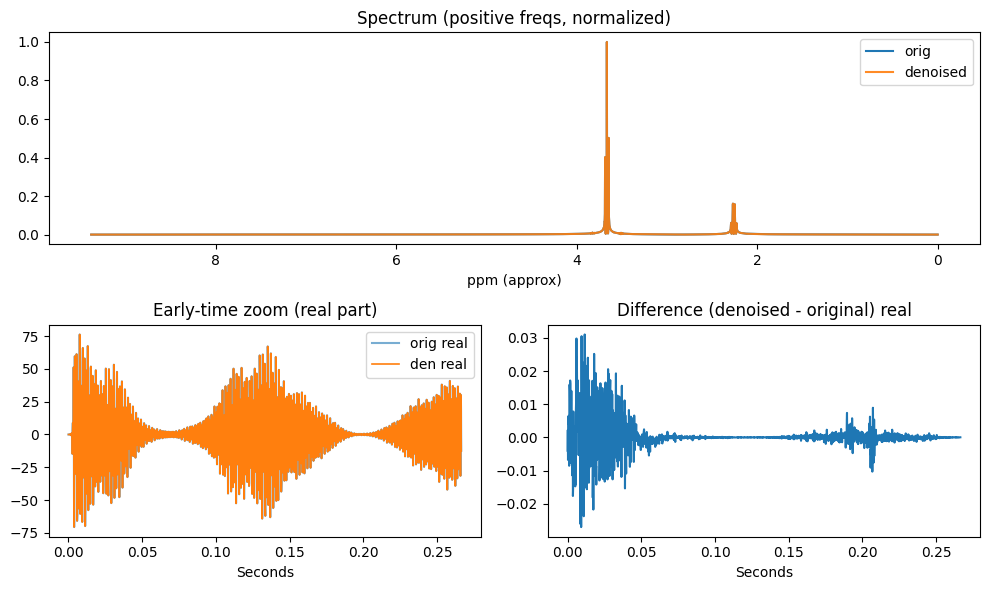

Identified functional groups:
The Peak at 2.25 ppm corresponds to a Benzylic / Next to Ar
The Peak at 2.27 ppm corresponds to a Benzylic / Next to Ar
The Peak at 3.65 ppm corresponds to a Halogen / O / N adjacent
The Peak at 3.67 ppm corresponds to a Halogen / O / N adjacent
The Peak at 3.69 ppm corresponds to a Halogen / O / N adjacent
Graph automatically zoomed to range: 2.15–3.79 ppm


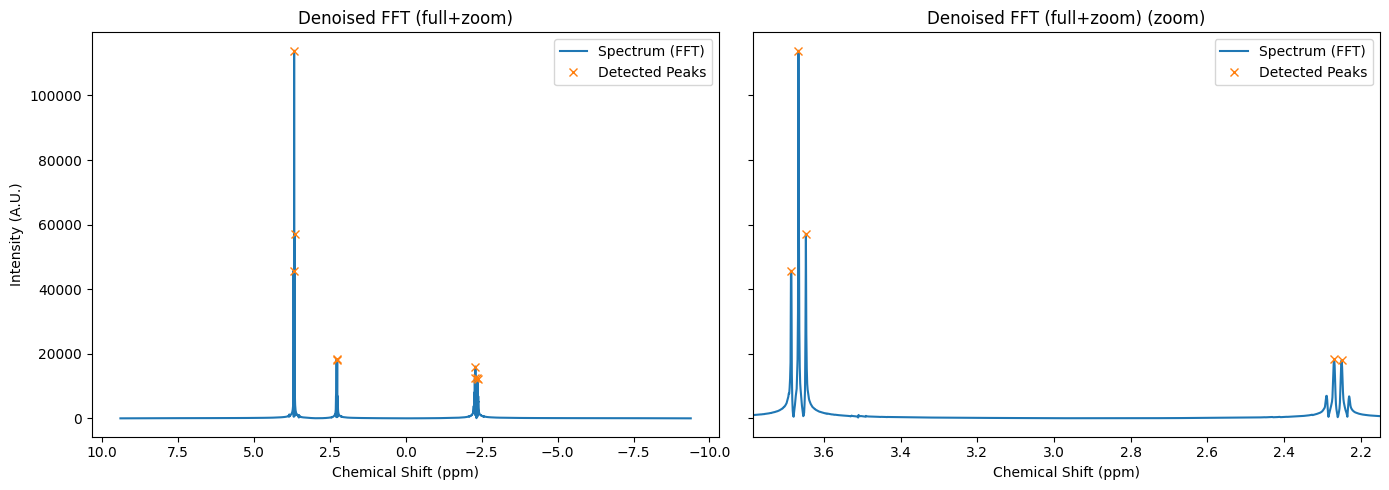

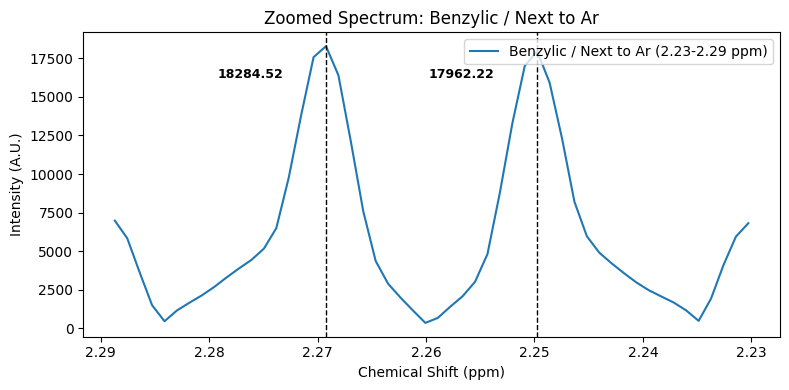

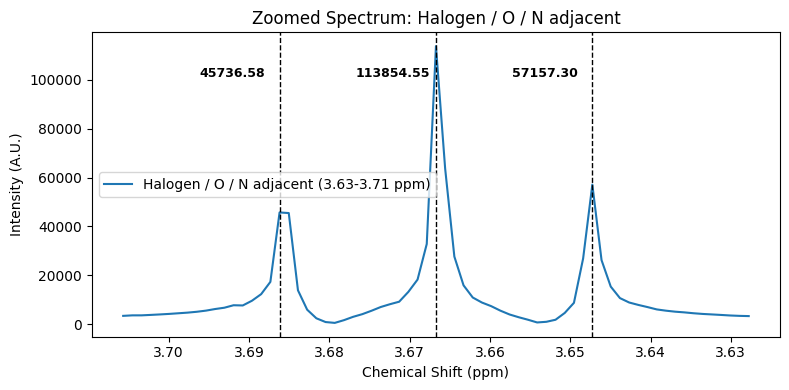


Numeric summary:
  MSE (time-domain, real+imag) = 1.988195e-06
  SNR orig = 24.265 dB | SNR den = 24.265 dB | ΔSNR = -0.000 dB

Top peak positions (ppm) — original:
[3.6667 3.6656 3.6472 3.6862 3.685 ]
Top peak positions (ppm) — denoised:
[3.6667 3.6656 3.6472 3.6862 3.685 ]
Approx peak shifts (ppm): [0. 0. 0. 0. 0.]

Recommendations:
 - Marginal change: ΔSNR within ±1 dB. To improve denoising, train on more examples or increase L1 smoothing weight slightly (e.g., 1e-5→1e-4).


In [8]:
# Unified FID analysis: MSE, SNR (dB), difference, FFT (ppm), early-time zoom, auto-zoom functional groups
import numpy as np
import torch
import matplotlib.pyplot as plt
from functions import nmr_function as nf
from functions.nmr_function import PPM_SHIFT_DEFAULTS

# Helper to coerce tensors/arrays to numpy (shape: (2, L) or (L, 2))
def to_np(a):
    if isinstance(a, torch.Tensor):
        return a.detach().cpu().squeeze(0).numpy()
    return np.asarray(a)

# Acquire data from notebook variables if present (fallback will raise informative error)
try:
    x = to_np(fid_tensor)   # expected shape (2, L) where 0=real,1=imag
    y = to_np(denoised)
    dt_local = float(dt)    # seconds per point
except NameError as e:
    raise RuntimeError(
        "Required variables not found in kernel. Ensure `fid_tensor`, `denoised`, and `dt` are defined before running this cell."
    )

# Normalize shapes: ensure shape (2, L)
if x.ndim == 1:
    raise ValueError("fid_tensor appears 1D; expected complex pair (real, imag).")
if x.shape[0] == 2 and x.shape[1] >= 1:
    pass
elif x.shape[1] == 2:
    x = x.T

if y.shape[0] != 2 and y.shape[1] == 2:
    y = y.T

L = x.shape[1]
# complex time-domain
zc = x[0] + 1j * x[1]
zd = y[0] + 1j * y[1]

# Envelope
env_x = np.sqrt(x[0]**2 + x[1]**2)
env_y = np.sqrt(y[0]**2 + y[1]**2)

# MSE (time-domain real+imag)
mse_val = float(np.mean((y - x)**2))

# SNR estimate: signal RMS from first 20%, noise from tail (last 20%)
start_sig = 0
end_sig = max(1, int(0.2 * L))
start_noise = int(0.8 * L)
end_noise = L
sig_rms_x = np.sqrt(np.mean(env_x[start_sig:end_sig]**2))
noise_rms_x = np.sqrt(np.mean(env_x[start_noise:end_noise]**2))
sig_rms_y = np.sqrt(np.mean(env_y[start_sig:end_sig]**2))
noise_rms_y = np.sqrt(np.mean(env_y[start_noise:end_noise]**2))

snr_x_db = 20 * np.log10((sig_rms_x / (noise_rms_x + 1e-12)))
snr_y_db = 20 * np.log10((sig_rms_y / (noise_rms_y + 1e-12)))
delta_snr_db = snr_y_db - snr_x_db

# FFT (full signed frequencies)
fft_x = np.fft.fft(zc)
fft_y = np.fft.fft(zd)
freqs = np.fft.fftfreq(L, d=dt_local)  # Hz (signed)
mag_x = np.abs(fft_x)
mag_y = np.abs(fft_y)

# Use your helper to present a ppm-aware spectrum (it expects frequencies and magnitudes)
spectrometer_freq = globals().get('nu0_MHz', 399.78219838)

# Use nf.plot_full_and_zoom_with_peaks to show full+zoom (it returns peaks & ppm axis)
spec_title = "Original vs Denoised (FFT)"
# Plot both spectra on same axes for visual comparison
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
# Positive-only view for visual clarity: take rfft equivalent
mask_pos = freqs >= 0
ppm_axis_pos = freqs[mask_pos] / spectrometer_freq
plt.plot(ppm_axis_pos, mag_x[mask_pos] / (mag_x[mask_pos].max() + 1e-12), label='orig')
plt.plot(ppm_axis_pos, mag_y[mask_pos] / (mag_y[mask_pos].max() + 1e-12), label='denoised', alpha=0.9)
plt.gca().invert_xaxis()
plt.xlabel('ppm (approx)')
plt.title('Spectrum (positive freqs, normalized)')
plt.legend()

# Early-time zoom + direct overlay
ax2 = plt.subplot(2, 2, 3)
early_N = min(2000, L)
t = np.arange(early_N) * dt_local
ax2.plot(t, zc.real[:early_N], label='orig real', alpha=0.6)
ax2.plot(t, zd.real[:early_N], label='den real', lw=1.2)
ax2.set_title('Early-time zoom (real part)')
ax2.set_xlabel('Seconds')
ax2.legend()

# Difference plot (real)
ax3 = plt.subplot(2, 2, 4)
ax3.plot(t, (zd.real - zc.real)[:early_N])
ax3.set_title('Difference (denoised - original) real')
ax3.set_xlabel('Seconds')

plt.tight_layout()
plt.show()

# Use provided helper for peak detection + optional auto-zoom by functional groups
# We'll call the helper on the positive (or full) FFT data
fft_result = nf.plot_full_and_zoom_with_peaks(freqs, mag_y, title='Denoised FFT (full+zoom)', spectrometer_freq=spectrometer_freq, ppm_shifts=PPM_SHIFT_DEFAULTS, identify_functional_groups=nf.identify_functional_groups, show=True)

# Identify groups for denoised and original (to compare centers/amplitudes)
identified_den = fft_result.get('identified_groups', [])
peaks_den = fft_result.get('peaks', [])
ppm_axis = fft_result.get('ppm_axis', freqs / spectrometer_freq)
intensity_den = fft_result.get('intensity', mag_y)

# If any functional groups found, auto-zoom each
if identified_den:
    try:
        nf.auto_zoom_functional_groups_with_integration(freqs, mag_y, identified_den, PPM_SHIFT_DEFAULTS, peak_data=[(ppm_axis[p], intensity_den[p]) for p in peaks_den], buffer=0.02)
    except Exception as e:
        print('Auto-zoom helper failed:', e)

# Numeric summary
print('\nNumeric summary:')
print(f'  MSE (time-domain, real+imag) = {mse_val:.6e}')
print(f'  SNR orig = {snr_x_db:.3f} dB | SNR den = {snr_y_db:.3f} dB | ΔSNR = {delta_snr_db:.3f} dB')

# Simple recommendation heuristics for loss weights (assumes you have w_env, w_freq, l1 in your training config)
recommendations = []
if delta_snr_db < -1.0:
    recommendations.append(('Increase smoothing', 'If ΔSNR < -1 dB, the denoiser reduced SNR: increase envelope/regularization weight (e.g., w_env *= 2) and add a small L1 (1e-4) on time-domain difference to encourage smoothing.'))
elif delta_snr_db > 1.0:
    recommendations.append(('Good SNR improvement', 'Model increased SNR. Check spectral fidelity: if peaks distorted, reduce aggressive smoothing (w_env *= 0.5) or increase w_freq to enforce spectral match.'))
else:
    recommendations.append(('Marginal change', 'ΔSNR within ±1 dB. To improve denoising, train on more examples or increase L1 smoothing weight slightly (e.g., 1e-5→1e-4).'))

# Also check if spectrum peaks were shifted: compare top-N peak ppm positions
try:
    # Find top peaks in original and denoised positive spectra
    pos = freqs >= 0
    mags_orig = mag_x[pos]
    mags_den = mag_y[pos]
    freqs_pos = freqs[pos]

    topN = 5
    idx_o = np.argsort(mags_orig)[-topN:][::-1]
    idx_d = np.argsort(mags_den)[-topN:][::-1]
    peaks_o_ppm = freqs_pos[idx_o] / spectrometer_freq
    peaks_d_ppm = freqs_pos[idx_d] / spectrometer_freq
    print('\nTop peak positions (ppm) — original:')
    print(np.round(peaks_o_ppm, 4))
    print('Top peak positions (ppm) — denoised:')
    print(np.round(peaks_d_ppm, 4))
    shifts = (peaks_d_ppm - peaks_o_ppm)
    print('Approx peak shifts (ppm):', np.round(shifts, 6))
    if np.max(np.abs(shifts)) > 0.01:
        recommendations.append(('Peak shift warning', f'Max peak shift ~{np.max(np.abs(shifts)):.4f} ppm; check spectral fidelity and consider increasing w_freq to penalize frequency-domain mismatch.'))
except Exception:
    pass

print('\nRecommendations:')
for tag, text in recommendations:
    print(f' - {tag}: {text}')

# Clean-up suggestion: replace earlier per-plot repetitive blocks with this single analysis cell to keep notebook tidy.


### Once me and Krish get a spectrum replace this with that FID

Make the FID into a torch instead of a numpy array so that now You can put it into pytorch.

The output says that we are processing 1 FID, we are working with 2 chanels (real vs imaginary) , and the length of that is x (depending on the particular FID)

#### use a bayesian torch here
would using a bayesian model help with the MRSE calcs?

# 🧠 Understanding the Dilated Conv FID Network

## 1️⃣ Parameters (Weights & Biases)

For a Conv1D layer:

$$
\text{Weights shape: } (C_{\text{out}}, C_{\text{in}}, K)
$$

- $C_{\text{in}}$ = input channels  
- $C_{\text{out}}$ = output channels  
- $K$ = kernel size  

**Number of weight parameters:**
$$
N_{\text{weights}} = C_{\text{out}} \times C_{\text{in}} \times K
$$

**Number of bias parameters:**
$$
N_{\text{bias}} =
\begin{cases}
C_{\text{out}} & \text{if bias exists} \\
0 & \text{otherwise}
\end{cases}
$$

**Total parameters per layer:**
$$
N_{\text{params}} = N_{\text{weights}} + N_{\text{bias}}
$$

> Example: First Conv1D: `(32, 2, 7)` → $(32 \times 2 \times 7 = 448)$ weights + 32 biases → 480 total params

---

## 2️⃣ Kernel Intuition

- Kernel = small 1D array of trainable numbers  
- Slides along FID → multiplies & sums → extracts local patterns (peaks, oscillations)  
- Each output channel has its own kernel for every input channel

---

## 3️⃣ Choosing Channels

- Input channels: $C_{\text{in}} = 2$ (Real + Imag FID)  
- Hidden channels: $C_{\text{hidden}} = 32$ (network capacity hyperparameter)  
- Output channels: same as input ($C_{\text{out}} = 2$)  

---

## 4️⃣ Dilation & Effective Kernel

**Dilation** = spacing between kernel elements:

$$
\text{Effective kernel size: } K_{\text{eff}} = D \cdot (K - 1) + 1
$$

- $D$ = dilation factor  
- $K_{\text{eff}}$ = how many original FID points a single output “sees”  
- Cumulative receptive field adds contributions from each layer:  

$$
\text{cum\_RF}_{i} = \text{cum\_RF}_{i-1} + K_{\text{eff}} - 1
$$

> Your network final layer sees 385 points of the original FID.

---

## 5️⃣ Residual Connections

- Each `DilatedResBlock` predicts a **residual**:  

$$
\text{output} = x + \text{residual}(x)
$$

- Helps learning: network focuses on **correcting noise** rather than recreating FID from scratch

---

## 6️⃣ Visual Intuition

- Input: FID `(batch, channels, length)`  
- Layers: conv1 → residual blocks → out  
- Each block expands **receptive field** via dilation  
- Visual: each ■ = output channel  